In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import pandas as pd
import numpy as np
import librosa
import seaborn as sns
import os
import json
import IPython.display as ipd
import soundfile as sf
import torch
import collections
import h5py
import timm
import torch.nn as nn
import onnxruntime as ort
import torchaudio

from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import chain
from os.path import join as pjoin
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram
from copy import deepcopy
from typing import Callable
from nnAudio.Spectrogram import CQT1992v2
# import leaf_audio_pytorch.frontend as frontend
from torchaudio.transforms import TimeMasking, FrequencyMasking
from shutil import copyfile
from torchaudio.transforms import Resample

# from code_base.utils import parallel_librosa_load, groupby_np_array, stack_and_max_by_samples, load_pp_audio
# from code_base.utils.constants import SAMPLE_RATE, N_CLASSES_2021_2022
from code_base.utils.onnx_utils import convert_to_onnx
from code_base.models import WaveCNNClasifier, WaveCNNAttenClasifier, WaveTDNNClasifier, RandomFiltering
from code_base.models.blocks import TraceableMelspec, NormalizeMelSpec, GeMFreqFixed, ChannelAgnosticAmplitudeToDB
# from code_base.models.wave_clasifier import WaveCNNAttenClasifier
from code_base.datasets import WaveDataset, WaveAllFileDataset
from code_base.utils import load_json, write_json
from code_base.utils.audio_utils import get_librosa_load
from code_base.schedulers import GradualWarmupSchedulerV2
# from code_base.augmentations.background_noise import AddBackgoundFromSoundScapes
# from code_base.augmentations.transforms import BackgroundNoise, Compose, GaussianNoise, PinkNoise, OneOf
# from code_base.forwards import MultilabelClsForwardLongShort
# from code_base.utils.onnx_utils import ONNXEnsemble, convert_to_onnx
from code_base.augmentations.transforms import (
    BackgroundNoise,
    Compose,
    GaussianNoise,
    OneOf,
    PinkNoise,
    TimeFlip
)
%matplotlib inline


/backup/vova/src/exps/bird_clef_2024/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/backup/vova/src/exps/bird_clef_2024/.venv/lib/python3.11/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


`speechbrain` was not imported
`LEAF` was not imported


In [ ]:
targets = torch.cat((torch.zeros(900, dtype=torch.long), torch.ones(100, dtype=torch.long)))

In [ ]:
class_sample_counts = np.bincount(targets)
weights = class_sample_counts.sum() / class_sample_counts 
# weights = 1. / class_sample_counts
sample_weights = weights[targets]

In [ ]:
class_sample_counts

In [ ]:
weights

In [ ]:
eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_FormixupAlpha05_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1

eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_FormixupAlpha05_balSampl_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1

eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCScoredDataNoSecLab_TimeFlip05_FormixupAlpha05_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1

eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCScoredDataNoSecLab_TimeFlip05_FormixupAlpha05_balSampl_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1

eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCScoredDataNoSecLab_TimeFlip05_FormixupAlpha05_balSamplas2024_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1

In [ ]:
!nvidia-smi

In [ ]:
# for logdir in os.listdir("../logdirs/"):
#     full_logdir_path = os.path.join(
#         "../logdirs",
#         logdir,
#         "code",
#         "train_configs___*"
#     )
#     all_current_train_configs = glob(full_logdir_path)
#     if len(all_current_train_configs) == 1:
#         copyfile(
#             all_current_train_configs[0],
#             os.path.join("../logdirs/", logdir + ".py")
#         )
#     # else:
#     #     print(logdir)

In [ ]:
# for el in glob("../logdirs/*"):
#     if os.path.isdir(el):
#         !rm {el} -r

In [ ]:
short_durs = [librosa.get_duration(path=el) for el in glob("comp_speed/comp_speed/080_input_text0_*")]
base_durs = [librosa.get_duration(path=el) for el in glob("comp_speed/comp_speed/100_input_text0_*")]
long_durs = [librosa.get_duration(path=el) for el in glob("comp_speed/comp_speed/150_input_text0_*")]

In [ ]:
glob("comp_speed/comp_speed/080_input_text0_*")

In [ ]:
short_durs

In [ ]:
base_durs

In [ ]:
len(short) / sr, len(base) / sr, len(long) / sr

In [ ]:
2.4380952380952383 / 3.1811337868480725

In [ ]:
4.760090702947846 / 3.1811337868480725

# Data

In [ ]:
def sample_uniformly_np_index(merged_intervals):
    # Calculate the total span of all intervals in terms of seconds
    total_seconds = sum(interval[1] - interval[0] for interval in merged_intervals)

    # Generate a random position within the total span as a float
    random_position = np.random.uniform(0, total_seconds)
    
    # Map the random position to an actual interval
    current_position = 0
    for index, (start, end, labels) in enumerate(merged_intervals):
        interval_length = end - start
        if current_position + interval_length > random_position:
            # Calculate the actual second within the interval as a float
            sampled_second = start + (random_position - current_position)
            return sampled_second, index
        current_position += interval_length

    raise RuntimeError("sample_uniformly_np_index was not able to pick chunk")

In [2]:
# df = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1.csv")
df = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/merged_train_metadata_extended_noduplv2.csv")
# df = pd.read_csv(
#     "/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1_GBirdV1.csv",
#     # converters={"label_second": eval}
# )
# df = pd.read_csv(
#     "/home/vova/src/exps/bird_clef_2024/google_bird_predictions/unlabeled_data/processed_data_v1_add_train.csv",
#     # converters={"label_second": eval}
# )
taxonomy = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/eBird_Taxonomy_v2021.csv")
previous_soundscapes = pd.read_csv(
    "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/v1_no_call_meta_fixed.csv"
)
scored_birds = load_json(
    "/home/vova/data/exps/birdclef_2024/scored_birds/sb_2024.json"
)
# df = pd.read_csv("/home/vova/data/exps/BirdCLEF_2023/xeno_canto/train_metadata_extended_shorten_and_2023x_v1.csv")
# df.head()

/tmp/ipykernel_1506982/3403899871.py:2: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/merged_train_metadata_extended_noduplv2.csv")


In [ ]:
df[df["label_second"].apply(lambda x: len(set(chain(*[el[-1] for el in x])))) > 1]

In [ ]:
df["label_second"].iloc[13]

In [ ]:
sample_uniformly_np_index(df["label_second"].iloc[13])

In [ ]:
seconds = [sample_uniformly_np_float(df["label_second"].iloc[13])[0] for _ in range(100000)]

In [ ]:
plt.hist(seconds, bins=100);

In [ ]:
# previous_soundscapes["filename"] = previous_soundscapes["filename"].apply(lambda x: os.path.join(
#     "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/train_audio", x
# ))

# def check_is_capable_to_load(path):
#     try:
#         librosa.load(path, sr=32000)
#         return True
#     except:
#         return False

# previous_soundscapes["is_corrupted"] = previous_soundscapes["filename"].apply(check_is_capable_to_load)

# or_previous_soundscapes = pd.read_csv(
#     "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/v1_no_call_meta.csv"
# )
# or_previous_soundscapes[previous_soundscapes["is_corrupted"]].reset_index(drop=True).to_csv(
#     "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/v1_no_call_meta_fixed.csv",
#     index=False
# )

In [ ]:
# previous_soundscapes["primary_label"] = "nocall"
# previous_soundscapes.to_csv(
#     "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/v1_no_call_meta.csv", index=False
# )

In [ ]:
df

In [ ]:
df.shape[0] / 64

In [ ]:
df["secondary_labels"].apply(eval).apply(len).value_counts()

In [ ]:
df

In [ ]:
df = df.sample(frac=1).reset_index(drop=True).iloc[:100]


In [ ]:
df["primary_label"].value_counts()

In [ ]:
df["duration_s"].iloc[:10].max()

In [ ]:
ab = 0.75
plt.hist(np.clip(np.random.beta(ab, ab, size=1000), 0.2, 0.8))

In [3]:
mel_spec_paramms={
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
}
mel_spec = nn.Sequential(
    TraceableMelspec(**mel_spec_paramms, quantizable=False),
    ChannelAgnosticAmplitudeToDB(top_db=80.0),
    NormalizeMelSpec(exportable=True),
)

STFT kernels created, time used = 0.3462 seconds


In [ ]:
background_module = BackgroundNoise(**{
    "esc50_root": "/home/vova/data/exps/birdclef_2024/birdclef_2024/unlabeled_soundscapes/",
    "esc50_df_path": "../pseudo/v1/negative_filtered_02.csv",
    "precompute": False,
    "load_normalize": False,
    "normalize_chunks": True,
    "normalize": True,
    "chunks_column": "nocall"
})

In [ ]:
audio = background_module.sample(32000 * 5)
spec = mel_spec(torch.from_numpy(audio)[None,...])
plt.imshow(spec[0])
ipd.Audio(audio, rate=32000)

In [ ]:
audio.shape[0] / 32000

In [ ]:
background_module.sample_names[1482]

In [ ]:
np.allclose(
    librosa.util.normalize(
        librosa.load(background_module.sample_names[1482], sr=32_000)[0][:5*32000]
    ), 
    audio
)

In [ ]:
# np.abs(background_module.sample(32000*5)).max()

In [ ]:
# np.abs(background_module._pick_random_valid_sample()).max()

In [4]:
train_dataset = WaveDataset(
    df=df,
    root="/home/vova/data/exps/birdclef_2024/birdclef_2024/train_features/",
    label_str2int_mapping_path="/home/vova/data/exps/birdclef_2024/class_mappings/bird2int_2024.json",
    # label_str2int_mapping_path="/home/vova/data/exps/birdclef_2024/class_mappings/bird2int_2024_PrevComp.json",
    precompute=False,
    n_cores=4,
    debug=False,
    # do_mixup=True,
    # mixup_params={
    #     "prob": 1.0, 
    #     "alpha": 1.0, 
    #     # "n_samples": 4,
    #     # "weights_path": "/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_add_data_v1.json"
    # },
    segment_len=5,
    late_normalize=True,
    sampler_col="stratify_col",
    # timewise_col="label_second",
    use_h5py=True,
    # shuffle=True,
    # add_df_paths=[
    #     "/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV3_meta_prev_comps_extended.csv"
    #     # "/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV3_scored_meta_prev_comps_extended_2024SecLabels.csv",
    #     # "/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV3_extended_2024SecLabels.csv"
    #     # "/home/vova/src/exps/bird_clef_2024/google_bird_predictions/unlabeled_data/processed_data_v1.csv"
    # ],
    filename_change_mapping={
        # "base": "birdclef_2024/train_audio/",
        # "comp_2021":"birdclef_2021/train_short_audio/",
        # "comp_2023":"birdclef_2023/train_audio/",
        # "comp_2022":"birdclef_2022/train_audio/",
        # "comp_2020":"birdsong_recognition/train_audio/",
        # "a_m_2020": "xeno_canto_bird_recordings_extended_a_m/A-M/",
        # "n_z_2020": "xeno_canto_bird_recordings_extended_n_z/N-Z/",
        # "xc_2024_classes": "xeno_canto/dataset_2024_classes/audio/",
        "soundscape": "birdclef_2024/unlabeled_soundscapes_features/",
        "base": "birdclef_2024/train_features/",
        "comp_2021":"birdclef_2021/train_features/",
        "comp_2023":"birdclef_2023/train_features/",
        "comp_2022":"birdclef_2022/train_features/",
        "comp_2020":"birdsong_recognition/train_features/",
        "a_m_2020": "xeno_canto_bird_recordings_extended_a_m/train_features/",
        "n_z_2020": "xeno_canto_bird_recordings_extended_n_z/train_features/",
        "xc_2024_classes": "xeno_canto/dataset_2024_classes/train_features/"
    },
    ignore_setting_dataset_value=True,
    soundscape_pseudo_df_path="../pseudo/v2/positive_filtered_075_cap_500.csv",
    # late_aug=TimeFlip(),
    # late_aug = Compose([
    #     BackgroundNoise(
    #         p=0.75,
    #         esc50_root="/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/train_audio",
    #         esc50_df_path="/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/v1_no_call_meta_fixed.csv",
    #         precompute=False,
    #         normalize=True,
    #         normalize_chunks=True,
    #         load_normalize=True,
    #         min_level=0.5,
    #         max_level=0.99,
    #         verbose=True
    #     ),
    #     PinkNoise(
    #         p=1.0,
    #         min_snr=0.5,
    #         max_snr=2.0,
    #         verbose=True
    #     ),
    # ]),
    # BackgroundNoise(
    #     p=1.0,
    #     esc50_root="/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/train_audio",
    #     esc50_df_path="/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/v1_no_call_meta_fixed.csv",
    #     precompute=False,
    #     normalize=True,
    #     normalize_chunks=True,
    #     load_normalize=True,
    #     min_level=0.5,
    #     max_level=0.99,
    #     verbose=True
    # ),
    # empty_soundscape_config={
    #     "prob": 0.35,
    #     "sampler_config": {
    #         "esc50_root": "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/train_audio",
    #         "esc50_df_path": "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/v1_no_call_meta_fixed.csv",
    #         "normalize": False,
    #         "precompute": False,
    #         "load_normalize": False,
    #     }
    # },
    # soundscape_pseudo_df_path="../pseudo/v1/positive_filtered_07_stratifyV2.csv",
    use_sampler=True,
    # start_from_zero=True,
    # sec_target_col=None
    # empty_soundscape_config={
    #     "prob": 0.5,
    #     "sampler_config": {
    #         "esc50_root": "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/train_audio",
    #         "esc50_df_path": "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/v1_no_call_meta.csv",
    #         "normalize": False,
    #         "debug": True
    #     }
    # }
)

# train_dataset_ss = WaveDataset(
#     df=previous_soundscapes,
#     root="/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/train_audio",
#     label_str2int_mapping_path="/home/vova/data/exps/birdclef_2024/class_mappings/bird2int_2024.json",
#     precompute=False,
#     n_cores=4,
#     debug=False,
#     do_mixup=True,
#     mixup_params={"prob": 0.5, "alpha": None},
#     segment_len=5,
#     late_normalize=True,
#     sampler_col="primary_label",
#     sec_target_col=None,
#     use_h5py=False,
#     use_sampler=True
# )

# train_dataset_full = WaveAllFileDataset(
#     df=df,
#     # root="/home/vova/data/exps/birdclef_2024/birdclef_2024/train_features/",
#     root="/home/vova/data/exps/birdclef_2024/birdclef_2024/train_audio",
#     label_str2int_mapping_path="/home/vova/data/exps/birdclef_2024/class_mappings/bird2int_2024.json",
#     precompute=False,
#     n_cores=4,
#     debug=False,
#     segment_len=5,
#     sample_id=None,
#     late_normalize=False,
#     use_h5py=False,
#     load_normalize=False,

#     use_audio_cache=True,
#     test_mode=True
# )

# merged_dataset = torch.utils.data.ConcatDataset([train_dataset, train_dataset_ss])

In [ ]:
train_dataset.df["filename_with_root"].iloc[0]

In [ ]:
train_dataset.df["stratify_col"].isna().sum()

In [ ]:
not_base_df = train_dataset.df[train_dataset.df["dataset"] != "base"].reset_index(drop=True)

In [ ]:
for fname in tqdm(not_base_df["filename_with_root"].to_list()):
    try:
        copyfile(
            fname, 
            os.path.join("/home/vova/data/exps/birdclef_2024/kaggle_datasets/bird_clef_2024_add_data/scored_add_data", os.path.basename(fname))
        )
    except Exception as e:
        fname = fname.replace(".ogg", ".mp3")
        copyfile(
            fname, 
            os.path.join("/home/vova/data/exps/birdclef_2024/kaggle_datasets/bird_clef_2024_add_data/scored_add_data", os.path.basename(fname))
        )

In [5]:
id2bird = {v:k for k,v in train_dataset.label_str2int.items()}

In [ ]:
len(set(train_dataset.df["primary_label"]))

In [ ]:
set(scored_birds) == set(train_dataset.df["primary_label"])

In [ ]:
train_dataset.df["dataset"].value_counts(normalize=True)

In [ ]:
train_dataset.df[train_dataset.df["dataset"] == "soundscape"]

In [ ]:
train_dataset.df[train_dataset.df.duration_s <= 5]

In [ ]:
train_dataset.df.duration_s.median()

In [ ]:
np.quantile(train_dataset.df.duration_s, 0.85)

In [ ]:
train_dataset.df.duration_s.hist(bins=30)

In [ ]:
train_dataset.df[train_dataset.df["dataset"] == "soundscape"]

In [ ]:
df.shape[0] / len(train_dataset), len(train_dataset)

In [ ]:
train_dataset[35530]

In [ ]:
len(train_dataset), len(train_dataset_ss), len(merged_dataset)

In [ ]:
pd.Series(train_dataset.targets).value_counts()

In [ ]:
all_tgts = pd.Series(train_dataset.targets)
sample_weights = (all_tgts.value_counts() / all_tgts.value_counts().sum())  ** (-0.5)
write_json(
    "/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_v1_pseudov1_StratV2.json",
    sample_weights.to_dict()
)

In [ ]:
# all_tgts = pd.Series(list(chain(*[ds.targets for ds in merged_dataset.datasets])))
# sample_weights = (all_tgts.value_counts() / all_tgts.value_counts().sum())  ** (-0.5)
# write_json(
#     "/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_add_data_v1_with_nocall.json",
#     sample_weights.to_dict()
# )

In [ ]:
class_weights = load_json("/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_add_data_v1_with_nocall.json")
sample_weights = np.array([
    class_weights[el] for el in list(chain(*[ds.targets for ds in merged_dataset.datasets]))
])
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

In [ ]:
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

loader = torch.utils.data.DataLoader(
    merged_dataset,
    worker_init_fn=worker_init_fn,
    sampler=sampler,
    **{
        "batch_size": 64,
        "shuffle": False,
        "drop_last": True,
        "num_workers": 0,
        "pin_memory": True,
    },
)

In [ ]:
len(loader)

In [ ]:

for idx, b in enumerate(loader):
    print(f"Empty Fraction: {(b[1].sum(axis=1) == 0).sum() / b[1].shape[0]}")
    if idx > 10:
        break

In [ ]:
(batch[1].sum(axis=1) == 0).sum() / batch[1].shape[0]

In [ ]:
au, tgt = train_dataset_ss[0]

In [ ]:
np.abs(au).max(), tgt.sum()

In [ ]:
train_dataset_full[0][0].min()

In [ ]:
train_dataset_full.test_audio_cache["au"].min()

In [ ]:
sorted(set(train_dataset.df["primary_label"]))

In [ ]:
train_dataset.df.loc[train_dataset.df["dataset"] == "xc_2024_classes", "primary_label"].value_counts()

In [ ]:
taxonomy

In [ ]:
taxonomy[taxonomy["PRIMARY_COM_NAME"].apply(lambda x: x.startswith("Intermediate Egret"))]

In [ ]:
train_dataset.df[(train_dataset.df["dataset"] == "xc_2024_classes") & (train_dataset.df["primary_label"] == "integr")]

In [ ]:
# train_dataset.df[train_dataset.df.primary_label == "brnfio1"]

In [ ]:
train_dataset.df[(train_dataset.df["dataset"] == "base") & (train_dataset.df["primary_label"] == "integr")]

In [ ]:
train_dataset.label_str2int["asbfly"]

In [ ]:
torch.where(train_dataset[22][1] > 0)[0]

In [ ]:
train_dataset.df["filename_with_root"].apply(os.path.exists).all()

In [ ]:
train_dataset.df.shape

In [ ]:
vc = train_dataset.df["url"].apply(lambda x: x.split("/")[-1]).value_counts()

In [ ]:
train_dataset.df[]

In [ ]:
train_dataset.df[train_dataset.df["url"].apply(lambda x: x.split("/")[-1]).isin(vc[vc > 1].index)].sort_values("url")

In [ ]:
sample_au, target_au = train_dataset[1000]

In [ ]:
sample_au.min(), sample_au.max()

In [ ]:
df[df["primary_label"] == "comtai1"].url

In [ ]:
sample_weights = pd.Series(load_json("/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_add_data_v1.json"))

In [ ]:
sample_weights

In [ ]:
sampled_birds = []
for _ in tqdm(range(1000)):
    sample_au, target_au = train_dataset[0]
    sampled_birds.extend([id2bird[el] for el in np.where(target_au > 0)[0]])

In [ ]:
pd.Series(sampled_birds).value_counts().iloc[1:20]

In [ ]:
train_dataset.df.primary_label.value_counts().iloc[1:20]

In [ ]:
train_dataset.df["label_second"]

In [ ]:
train_dataset.df[train_dataset.df["label_second"].apply(lambda x: len(set(chain(*[el[-1] for el in x])))) > 1]

In [ ]:
train_dataset.df[
    (train_dataset.df["label_second"].apply(lambda x: x[-1][1] - x[-1][0]) < 2.5) &
    (train_dataset.df["label_second"].apply(len) == 1) &
    (train_dataset.df["duration_s"] > 5)
]

In [ ]:
train_dataset.df[train_dataset.df["duration_s"] < 5]

In [ ]:
int((27.35021875 - 5) * 32000)

In [ ]:
(33.64571875 - 5) * 32000

In [ ]:
(30 - 2.5) * 32000

In [ ]:
train_dataset.df[train_dataset.df.duration_s <= 5]

In [ ]:
mel_spec_paramms={
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
}
mel_spec = nn.Sequential(
    TraceableMelspec(**mel_spec_paramms, quantizable=False),
    AmplitudeToDB(top_db=80.0),
    NormalizeMelSpec(exportable=True),
)
mel_spec_new = nn.Sequential(
    TraceableMelspec(**mel_spec_paramms, quantizable=False),
    ChannelAgnosticAmplitudeToDB(top_db=80.0),
    NormalizeMelSpec(exportable=True),
)

In [ ]:
train_dataset.df.loc[train_dataset.df["dataset"] == "soundscape", "primary_label"].value_counts().head(20)

In [ ]:
train_dataset.df[
    (train_dataset.df["primary_label"] == "whcbar1") &
    (train_dataset.df["dataset"] != "soundscape")
]

In [ ]:
class_name = "brcful1"

In [ ]:
# sample_au, target_au = train_dataset[0]
# sample_id = np.random.randint(0, len(train_dataset))
sample_id = 55132 #np.random.choice(train_dataset.df[
#     (train_dataset.df["primary_label"] == class_name) &
#     (train_dataset.df["dataset"] == "soundscape")
# ].index)
print("Sample ID", sample_id)
sample_au, target_au = train_dataset[sample_id]

print("Target IDS:", np.where(target_au > 0)[0])
print("Birds: ", [id2bird[el] for el in np.where(target_au > 0)[0]])

# plt.figure(figsize=(20,10))
spec = mel_spec(torch.from_numpy((sample_au))[None,...]) ** 1
plt.imshow(spec[0])
plt.show()

ipd.Audio(sample_au, rate=32000)

X shape in Norm torch.Size([1, 128, 313])


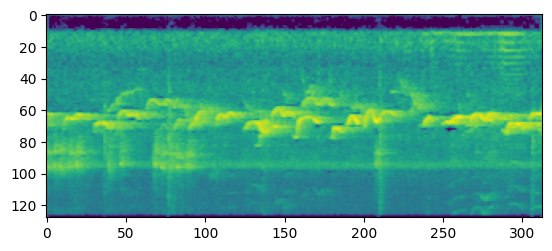

In [46]:
# sample_au, target_au = train_dataset[0]
sample_id = 3770 #np.random.choice(train_dataset.df[
#     (train_dataset.df["primary_label"] == class_name) &
#     (train_dataset.df["dataset"] != "soundscape")
# ].index)
print("Sample ID", sample_id)
sample_au, target_au = train_dataset[sample_id]

print("Target IDS:", np.where(target_au > 0)[0])
print("Birds: ", [id2bird[el] for el in np.where(target_au > 0)[0]])

# plt.figure(figsize=(20,10))
spec = mel_spec(torch.from_numpy((sample_au))[None,...]) #** 0.6080866059834527
plt.imshow(spec[0])
plt.show()

ipd.Audio(sample_au, rate=32000)

In [ ]:
(spec - spec_new).abs().amax(axis=(1,2))

In [ ]:
target_au

In [ ]:
sample_au_full, sample_sr_full = librosa.load(
    train_dataset.df["filename_with_root"].iloc[sample_id].replace("train_features", "train_audio").replace(".hdf5", ".ogg"),
    sr=None
)
plt.imshow(mel_spec(torch.from_numpy(sample_au_full[2097528:2097528 + 5*32000])[None,...])[0])

In [ ]:
np.allclose(sample_au, librosa.util.normalize(sample_au_full[2097528:2097528 + 5*32000]))

In [ ]:
sample_au.shape

In [ ]:
sample_au[:sample_sr*,]

In [ ]:
np.abs(sample_au).max()

In [ ]:
ipd.Audio(sample_au, rate=32000)

In [ ]:
# sample_au, target_au = train_dataset[0]
sample_au, target_au = train_dataset[35706]

plt.figure(figsize=(20,10))
spec = mel_spec(torch.from_numpy(sample_au)[None,...])
plt.imshow(spec[0])
plt.show()

In [ ]:
ipd.Audio(sample_au, rate=32000)

In [ ]:
check_labels = torch.stack([train_dataset_full[idx][1] for idx in range(990,990+30)])

In [ ]:
torch.where(check_labels > 0)[1]

In [ ]:
train_dataset_full.df.iloc[120]

In [ ]:
train_dataset_full.sampleidx_2_dfidx[991]

In [ ]:
original_sample = librosa.load("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_audio/asbfly/XC134896.ogg", sr=32000)[0]

In [ ]:
librosa.util.normalize(original_sample[:32000*5])

In [ ]:
full_sample_au, full_target_au, dfidx, start, end = train_dataset_full[1]

In [ ]:
np.allclose(full_sample_au, librosa.util.normalize(original_sample[32000*5:32000*10]))

In [ ]:
ipd.Audio(sample_au_aug, rate=32000)

In [ ]:
target_au_aug

In [ ]:
maybe_dupl1 = librosa.util.normalize(librosa.load(
    "/home/vova/data/exps/birdclef_2024/birdclef_2022/train_audio/brant/XC294370.ogg", sr=32000
)[0])
maybe_dupl2 = librosa.util.normalize(librosa.load(
    "/home/vova/data/exps/birdclef_2024/birdclef_2022/train_audio/gadwal/XC294370.ogg", sr=32000
)[0])

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(mel_spec(torch.from_numpy(maybe_dupl1)[None,...])[0])
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(mel_spec(torch.from_numpy(maybe_dupl2)[None,...])[0])
plt.show()

In [ ]:
# ipd.Audio(sample_au, rate=32_000)

In [ ]:
ipd.Audio(sample_au_aug, rate=32_000)

In [ ]:
np.abs(sample_au_aug).max()

In [ ]:
torch.unique(target_au_aug), torch.sum(target_au_aug)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(my_spec(torch.from_numpy(sample_au_aug)[None,:])[0])
plt.show();

In [ ]:
target_au.max()

In [ ]:
torch.allclose(target_au, target_au_aug)

In [ ]:
np.abs(sample_au - sample_au_aug).max()

In [ ]:
plt.plot(sample_au)

In [ ]:
plt.plot(sample_au_aug)

In [ ]:
ipd.Audio(sample_au, rate=32000)

In [ ]:
ipd.Audio(sample_au_aug, rate=32000)

In [ ]:
np.allclose(sample_au, sample_feat)

In [ ]:
# train_dataset = WaveDataset(
#     df=df,
#     root="/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_audio/",
#     label_str2int_mapping_path="/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/bird2int_2023.json",
#     precompute=False,
#     n_cores=32,
#     debug=True,
#     do_mixup=False,
#     # mixup_params={"prob": 0.5, "alpha": None},
#     segment_len=5.0,
#     late_normalize=True,
#     sec_target_col=None
# )

# train_dataset_extended = WaveDataset(
#     df=df,
#     root="/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_audio/",
#     label_str2int_mapping_path="/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/bird2int_2023.json",
#     precompute=True,
#     n_cores=32,
#     debug=False,
#     do_mixup=True,
#     mixup_params={"prob": 0.5, "alpha": None},
#     segment_len=5.0,
#     late_normalize=True,
#     add_df_paths=[
#         "/home/vova/data/exps/BirdCLEF_2023/train_metadata_extended_2020_2022_no2023_scored.csv"
#     ],
#     sampler_col="sw_col"
# )

In [ ]:
train_dataset[11][1].sum()

In [ ]:
train_dataset.df[train_dataset.df.secondary_labels.apply(len) > 1]

In [ ]:
train_dataset_extended.df[]

In [ ]:
set(train_dataset_extended.df["sw_col"]) - set(load_json("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/scored_birds.json"))

In [ ]:
train_dataset_extended.df["filename_with_root"].iloc[-1]

In [ ]:
sample_au, sample_label = train_dataset[0]
sample_au = torch.from_numpy(sample_au)[None,:]

In [ ]:
sample_au_spec = model.forward(sample_au, return_spec_feature=True)

In [ ]:
plt.imshow(sample_au_spec[0].numpy())

In [ ]:
# ipd.Audio(sample_au, rate=32_000)

In [ ]:
aug_block = RandomFiltering(
    min_db=-20,
    is_wave=True,
    normalize_wave=True
)

In [ ]:
auged_sample_au = aug_block(sample_au)

In [ ]:
auged_sample_au_spec = model.forward(auged_sample_au, return_spec_feature=True)

In [ ]:
plt.imshow(auged_sample_au_spec[0].numpy())

In [ ]:
plt.imshow(auged_sample_au_spec[0].numpy() - sample_au_spec[0].numpy())

In [ ]:
ipd.Audio(auged_sample_au, rate=32_000)

In [ ]:
valid_dataset = WaveAllFileDataset(
    df=df,
    root="/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_audio/",
    label_str2int_mapping_path="/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/bird2int_2023.json",
    precompute=True,
    n_cores=32,
    debug=True,
    segment_len=5,
    lookback=2.5,
    lookahead=2.5,
    late_normalize=True,
    sample_id=None
)

In [ ]:
sample_au, sample_label, sample_df_id, sample_start, sample_end_s = valid_dataset[0]

In [ ]:
len(sample_au) / 32_000

In [ ]:
sample_au

# Sounscapes

In [ ]:
un_ss = glob("/home/vova/data/exps/birdclef_2024/birdclef_2024/unlabeled_soundscapes/*.ogg")

In [ ]:
pseudo = pd.read_csv("../pseudo/v1/positive_filtered_07.csv", converters={"all_labels": eval})

In [ ]:
pseudo

In [ ]:
un_ss

In [ ]:
pseudo["sample_id"] = pseudo["row_id"].apply(lambda x: x.split("_")[0])

In [ ]:
pseudo

In [ ]:
pseudo[pseudo["sample_id"] == "100238396"]

In [ ]:
pseudo_samples

In [ ]:
df_idx = 6143

In [ ]:
sample_idx, end_second = pseudo["row_id"].iloc[df_idx].split("_")

sample, _ = librosa.load(
    # un_ss[500], 
    f'/home/vova/data/exps/birdclef_2024/birdclef_2024/unlabeled_soundscapes/{sample_idx}.ogg',
    sr=None
)
# sample = librosa.util.normalize(sample)

In [ ]:
sample_slice = sample[32000*(int(end_second) - 5):32000*int(end_second)]
ipd.Audio(sample_slice, rate=32000)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(mel_spec(torch.from_numpy(sample_slice)[None,...])[0])
plt.show()

# Compare librosa and torchaudio

In [ ]:
librosa_loaded = librosa.load("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_audio/asbfly/XC453302.ogg", sr=32000)[0]

In [ ]:
torchaudio_loaded, torchaudio_sr = torchaudio.load("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_audio/asbfly/XC453302.ogg")
torchaudio_loaded = Resample(orig_freq=torchaudio_sr, new_freq=16000)(torchaudio_loaded)[0]

In [ ]:
torchaudio_loaded.shape

In [ ]:
librosa_loaded.shape

In [ ]:
len(librosa_loaded) / 32000

In [ ]:
len(torchaudio_loaded) / 32000

In [ ]:
np.abs(torchaudio_loaded[len(torchaudio_loaded) - len(librosa_loaded):] - librosa_loaded).max()

In [ ]:
np.abs(torchaudio_loaded[:len(librosa_loaded)] - librosa_loaded).max()

In [ ]:
np.allclose(torchaudio_loaded[:len(librosa_loaded)], librosa_loaded)

In [ ]:
len(librosa_loaded) / 32000

In [ ]:
len(torchaudio_loaded) / 32000

# Spectogram

In [ ]:
test_pred = pd.read_csv("submission.csv")

In [ ]:
np.sort(test_pred.iloc[:,1:].values.flatten())[-20:]

In [ ]:
np.where(test_pred.iloc[:,1:].max(axis=1) > 0.9)

In [ ]:
test_pred.iloc[65]

In [ ]:
test_audio, test_sr = librosa.load("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/test_soundscapes/soundscape_29201.ogg", sr=None)
test_audio = librosa.util.normalize(test_audio)

In [ ]:
test_sr

In [ ]:
ipd.Audio(
    test_audio[test_sr*0:test_sr*5],
    rate=test_sr
)

In [ ]:
test_sr

In [ ]:
test_pred.iloc[65].iloc[1:].sort_values()

In [ ]:
mel_spec_paramms={
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
}
mel_spec = nn.Sequential(
    TraceableMelspec(**mel_spec_paramms, quantizable=False),
    AmplitudeToDB(top_db=80.0),
    NormalizeMelSpec(exportable=True),
)

# leaf_spec = {
#     "sample_rate": 32000,
#     "n_filters": 128,
#     # "window_stride": 15
# }

# leaf_complex = nn.Sequential(
#     frontend.Leaf(**leaf_spec, onnx_export=True, compression_fn=None),
#     AmplitudeToDB(top_db=80.0),
#     NormalizeMelSpec(exportable=True),
# )

# leaf_noncomplex = nn.Sequential(
#     frontend.Leaf(**leaf_spec, onnx_export=True),
#     NormalizeMelSpec(exportable=True),
# )

In [ ]:
spec = mel_spec(torch.from_numpy(librosa.util.normalize(test_audio[
    test_sr*0:
    test_sr*5
]))[None,:])
spec = torch.cat([spec,spec,spec])

# leaf_1 = leaf_complex(torch.from_numpy(librosa.util.normalize(test_audio[
#     test_sr*0:
#     test_sr*5
# ]))[None,:])
# leaf_2 = leaf_noncomplex(torch.from_numpy(librosa.util.normalize(test_audio[
#     test_sr*0:
#     test_sr*5
# ]))[None,:])

In [ ]:
class CustomMasking(nn.Module):
    def __init__(
        self,
        mask_max_length: int,
        mask_max_masks: int,
        p=1.0,
        inplace=True
    ):
        super().__init__()
        assert isinstance(mask_max_masks, int) and mask_max_masks > 0 
        self.mask_max_masks = mask_max_masks
        self.mask_max_length = mask_max_length
        self.mask_module = None
        self.p = p
        self.inplace = inplace
    
    def forward(self, x):
        if not self.inplace:
            output = x.clone()
        for i in range(x.shape[0]):
            if np.random.binomial(n=1, p=self.p):
                n_applies = np.random.randint(low=1, high=self.mask_max_masks+1)
                print(f"Applying {n_applies} times")
                for _ in range(n_applies):
                    if self.inplace:
                        x[i:i+1] = self.mask_module(x[i:i+1])
                    else:
                        output[i:i+1] = self.mask_module(output[i:i+1])
        if self.inplace:
            return x
        else: 
            return output
        
class CustomTimeMasking(CustomMasking):
    def __init__(
        self,
        mask_max_length: int,
        mask_max_masks: int,
        p=1.0,
        inplace=True
    ):
        super().__init__(
            mask_max_length=mask_max_length,
            mask_max_masks=mask_max_masks,
            p=p,
            inplace=inplace
        )
        self.mask_module = TimeMasking(
            time_mask_param=mask_max_length
        )
        
class CustomFreqMasking(CustomMasking):
    def __init__(
        self,
        mask_max_length: int,
        mask_max_masks: int,
        p=1.0,
        inplace=True
    ):
        super().__init__(
            mask_max_length=mask_max_length,
            mask_max_masks=mask_max_masks,
            p=p,
            inplace=inplace
        )
        self.mask_module = FrequencyMasking(
            freq_mask_param=mask_max_length
        )

In [ ]:
np.random.randint(low=1, high=1+1)

In [ ]:
# time_masking = CustomTimeMasking(
#     mask_max_length=20,
#     mask_max_masks=3,
#     p=0.5,
#     inplace=True
# )
# freq_masking = CustomFreqMasking(
#     mask_max_length=10,
#     mask_max_masks=3,
#     p=0.5,
#     inplace=True
# )

In [ ]:
both_masking = nn.Sequential(
    CustomTimeMasking(
        mask_max_length=20,
        mask_max_masks=3,
        p=0.3,
        inplace=True
    ),
    CustomFreqMasking(
        mask_max_length=10,
        mask_max_masks=3,
        p=0.3,
        inplace=True
    )
)

In [ ]:
# time_masked = time_masking(spec)
# freq_masked = freq_masking(spec)

both_masked = both_masking(spec)

In [ ]:
swin = timm.create_model(
    "swinv2_tiny_window8_256", 
    in_chans=1, 
    # features_only=True,
    dropout_rate=0.2,
    num_classes=20
)
# swin.head.drop.p = 0.4
# swin.head = nn.Identity()

In [ ]:
swin.head

In [ ]:
swin.train();

In [ ]:
swin.head.drop.p = 0.4

In [ ]:
swin(spec[:,None,:,:])[-1]

In [ ]:
torch.abs(leaf_1- leaf_2).max()

In [ ]:
time_masked = time_masking(spec[0])
freq_masked = freq_masking(spec[0])

In [ ]:
# time_masked = time_masking(spec)
# freq_masked = freq_masking(spec)

plt.figure(figsize=(10,10))
plt.imshow(spec[0].detach().cpu().numpy())
plt.show();

plt.figure(figsize=(10,10))
plt.imshow(spec[1].detach().cpu().numpy())
plt.show();

plt.figure(figsize=(10,10))
plt.imshow(spec[2].detach().cpu().numpy())
plt.show();

# plt.figure(figsize=(10,10))
# plt.imshow(both_masked[0].detach().cpu().numpy())
# plt.show();

# plt.figure(figsize=(10,10))
# plt.imshow(both_masked[1].detach().cpu().numpy())
# plt.show();

# plt.figure(figsize=(10,10))
# plt.imshow(both_masked[2].detach().cpu().numpy())
# plt.show();

# plt.figure(figsize=(10,10))
# plt.imshow(freq_masked[0].detach().cpu().numpy())
# plt.show();

# plt.figure(figsize=(10,10))
# plt.imshow(freq_masked[1].detach().cpu().numpy())
# plt.show();

# plt.figure(figsize=(10,10))
# plt.imshow(freq_masked[2].detach().cpu().numpy())
# plt.show();

# plt.figure(figsize=(10,10))
# plt.imshow(freq_masked[0].detach().cpu().numpy())
# plt.show();

In [ ]:
test_audio, test_sr = librosa.load("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_audio/pygbat1/XC755905.ogg", sr=None)
test_audio = librosa.util.normalize(test_audio)

In [ ]:
test_sr

In [ ]:
spec = my_spec(torch.from_numpy(librosa.util.normalize(test_audio))[None,:])
# cqt_spec = cqt(torch.from_numpy(sample_au)[None,:])

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(spec[0])
plt.show();
# plt.imshow(cqt_spec[0])
# plt.show();

In [ ]:
spec.shape, cqt_spec.shape

In [ ]:
spec.max(), spec.min()

In [ ]:
cqt_spec.max(), cqt_spec.min()

# Tune Scheduler

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

In [ ]:
def visualise_lr_scheduling(lr_scheduler_from_opt, n_steps, verbose=True, lr=1e-3):
    # t_opt = torch.optim.SGD([torch.tensor(1)], lr=lr)
    t_opt = torch.optim.SGD([
        {'params': torch.tensor(1), 'lr': lr},
        # {'params': torch.tensor(1), 'lr': lr/20}
    ])
    t_sched = lr_scheduler_from_opt(t_opt)
    lrs = []
    for i in range(n_steps):
        t_opt.step()
        lrs.append(t_sched.get_lr()[0])
        t_sched.step()
        
    if verbose:
        plt.title("Learning Rate Schedule")
        plt.xlabel("Iteration")
        plt.ylabel("Learning Rate")
        plt.plot(lrs)
        plt.show()
        
    print(f"Min LR : {min(lrs)}. Max LR: {max(lrs)}")
    return lrs

In [ ]:
visualise_lr_scheduling(
    lr_scheduler_from_opt=lambda opt: GradualWarmupSchedulerV2(
        optimizer=opt, 
        multiplier=10,
        total_epoch=5,
        after_scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(
            opt,
            T_max=45,
            eta_min=1e-7
        )
    ),
    n_steps=50+2,
    lr=1e-5
);

# Model

In [ ]:
timm.list_models("tf_efficientnetv2*")

In [ ]:
backbone_model = timm.create_model("efficientformerv2_s2.snap_dist_in1k", features_only=True)

In [ ]:
backbone_model

In [48]:
TRAIN_PERIOD = 5.0

# model_config = dict(
#     backbone="eca_nfnet_l0",
#     add_backbone_config={
#         "drop_path_rate": 0.2
#     },
#     mel_spec_paramms={
#         "sample_rate": 32000,
#         "n_mels": 128,
#         "f_min": 20,
#         "n_fft": 2048,
#         "hop_length": 512,
#         "normalized": True,
#     },
#     head_config={
#         "p": 0.5,
#         "num_class": 264,
#         "train_period": TRAIN_PERIOD,
#         "infer_period": TRAIN_PERIOD,
#     },
#     exportable=True,
#     # deep_supervision_steps=3
# )
model_config = dict(
    backbone="tf_efficientnetv2_b1.in1k",
    mel_spec_paramms={
        "sample_rate": 32000,
        "n_mels": 128,
        "f_min": 20,
        "n_fft": 2048,
        "hop_length": 512,
        "normalized": True,
    },
    spec_augment_config={
        "power_aug":{
            "power_range": (0.5, 3.0),
            "p": 1.0,
            "inplace": True
        },
        "freq_mask": {
            "mask_max_length": 20,
            "mask_max_masks": 3,
            "p": 0.7,
            "inplace": True,
        },
        "time_mask": {
            "mask_max_length": 30,
            "mask_max_masks": 3,
            "p": 0.7,
            "inplace": True,
        },
    },
    head_config={
        "p": 0.5,
        "num_class": 998,
        "train_period": TRAIN_PERIOD,
        "infer_period": TRAIN_PERIOD,
    },
    exportable=True,
    fixed_amplitude_to_db=True
)

model = WaveCNNAttenClasifier(**model_config, device="cpu")

model.train();

STFT kernels created, time used = 0.1014 seconds


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [62]:
spec = model.forward(torch.from_numpy(sample_au)[None,...], return_spec_feature=True)

X shape in Norm torch.Size([1, 128, 313])
2.380389383227606
X shape in Norm torch.Size([1, 128, 313])


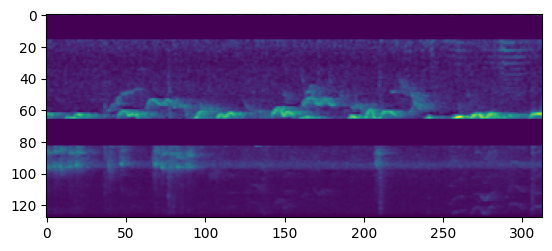

In [63]:
plt.imshow(spec[0,0])

In [39]:
spec[0,0].min()

tensor(0.)

In [ ]:
sample = torch.randn(4, int(32000 * TRAIN_PERIOD))

In [ ]:
with torch.no_grad():
    out = model(sample)

In [ ]:
out["clipwise_pred_long"]

In [ ]:
out_2["clipwise_pred_long"]

In [ ]:
out_old["clipwise_pred_long"]

In [ ]:
out_old_2["clipwise_pred_long"]

In [ ]:
both_masking = nn.Sequential(
    CustomTimeMasking(
        mask_max_length=20,
        mask_max_masks=3,
        p=0.3,
        inplace=True
    ),
    CustomFreqMasking(
        mask_max_length=10,
        mask_max_masks=3,
        p=0.3,
        inplace=True
    )
)

In [ ]:
128 / 8

In [ ]:
256 / 8

In [ ]:
model

In [ ]:
sample_au = torch.from_numpy(sample_au)[None,...]
# sample_au = torch.stack([sample_au, sample_au, sample_au, sample_au])

In [ ]:
spec = model.forward(
    sample_au,
    # torch.from_numpy(sample_au)[None,...],
    return_spec_feature=True
)

In [ ]:
spec

In [ ]:
len(spec)

In [ ]:
plt.imshow(spec[0,0].detach())

In [ ]:
plt.imshow(spec[0,0].detach())

In [ ]:
some_backbone = timm.create_model(
    "eca_nfnet_l0",
    features_only=True,
    pretrained=True,
    exportable=True,
    in_chans=2,
    out_indices=None
)
some_backbone.eval();

In [ ]:
some_backbone.feature_info.info

In [ ]:
sample_input = torch.randn((1,2,256,256))

In [ ]:
sample_input.mean((2,3), keepdims=True)

In [ ]:
type(sample_output_1)

In [ ]:
with torch.no_grad():
    sample_output_2 = some_backbone(sample_input)

In [ ]:
len(sample_output_1), len(sample_output_2)

In [ ]:
torch.allclose(sample_output_1[3], sample_output_2[1])

In [ ]:
sample = torch.randn((4, int(TRAIN_PERIOD*32_000)))

In [ ]:
model(sample)["clipwise_pred"].shape

In [ ]:
sample = torch.from_numpy(librosa.util.normalize(test_audio[
    test_sr*0:
    test_sr*5
]))[None,:]

In [ ]:
sample.shape

In [ ]:
spec = model.logmelspec_extractor(sample)

In [ ]:
spec.shape

In [ ]:
spec.shape

In [ ]:
model.logmelspec_extractor

In [ ]:
embs = model.backbone(spec)

In [ ]:
# model.train();
model.eval();
embs = model.forward(sample, return_spec_feature=True)

In [ ]:
plt.imshow(embs[0,0])

In [ ]:
embs["clipwise_pred_long"].min()

In [ ]:
embs.shape

In [ ]:
len(embs)

In [ ]:
model.forward(sample)

In [ ]:
embs.transpose()

In [ ]:
# torch.Size([4, 2304, 4, 10])

In [ ]:
len(embs)

In [ ]:
probs = model.forward(sample)

In [ ]:
probs

In [ ]:
embs[2].shape

In [ ]:
pool_layers = nn.ModuleList([
    GeMFreqFixed(time_kernel_size=k*2 if k>0 else 1) for k in list(reversed(range(len(embs))))
])

In [ ]:
pooled_embs = [p(emb) for p, emb in zip(pool_layers, embs)]

In [ ]:
for i in range(len(embs)):
    print(pooled_embs[i].shape, embs[i].shape)

In [ ]:
pooled_embs[3].shape, embs[3].shape

In [ ]:
[k*2 if k>0 else 1 for k in list(reversed(range(len(embs))))]

In [ ]:
list(reversed(range(1, len(embs))))

In [ ]:
[el.shape for el in embs]

In [ ]:
avg_pool = torch.nn.AvgPool2d(kernel_size=(2,2))

In [ ]:
avg_pool(embs[-2]).shape

In [ ]:
spec = model(sample)

In [ ]:
spec.shape

In [ ]:
!rm test_onnx -rf

In [ ]:
model.eval()
convert_to_onnx(
    model_to_convert=model,
    sample_input=torch.randn(4, int(TRAIN_PERIOD * 32_000)),
    # base_path=f"../logdirs/tf_efficientnetv2_m_in21ft1k_convnext_tiny_in22ft1k_eca_nfnet_l0_noval_v3AllTune_075Clipwise025TimeMax_GausMean/onnx_ensem"
    base_path="test_onnx"
)

In [ ]:
model = ort.InferenceSession(f"test_onnx/model_simpl.onnx")

In [ ]:
out = model.run(None, {"input": torch.randn(4, int(TRAIN_PERIOD * 32_000)).numpy()})[0]

In [ ]:
out.shape

In [ ]:
out

# Prepare final datasets

In [ ]:
train_metadata_extended_202x = pd.read_csv(
    "/home/vova/data/exps/BirdCLEF_2023/train_metadata_extended_2020_2022_no2023_scored_nodupl_v1_only_prime_2023SecLabels.csv"
)
xc_add_first = pd.read_csv(
    "/home/vova/data/exps/BirdCLEF_2023/xeno_canto/scored_2023_xc_2023SecLabels.csv"
)
xc_add_second = pd.read_csv(
    "/home/vova/data/exps/BirdCLEF_2023/xeno_canto/scored_2023_xc_2023SecLabels_till_12_05_2023_v2.csv"
)

In [ ]:
xc_add_first.filename.iloc[0]

In [ ]:
for fname in tqdm(xc_add_second["filename"]):
    splitted_fname = fname.split("/")
    new_fname = os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/audio/", splitted_fname[-2], splitted_fname[-1])
    if not os.path.exists(os.path.dirname(new_fname)):
        os.makedirs(os.path.dirname(new_fname))
    copyfile(
        fname,
        os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/audio/", splitted_fname[-2], splitted_fname[-1])
    )

In [ ]:
def modify_name(input):
    splitted_fname = input.split("/")
    return os.path.join(splitted_fname[-2], splitted_fname[-1])

In [ ]:
train_metadata_extended_202x["filename"] = train_metadata_extended_202x["filename"].apply(modify_name)
xc_add_first["filename"] = xc_add_first["filename"].apply(modify_name)
xc_add_second["filename"] = xc_add_second["filename"].apply(modify_name)

In [ ]:
train_metadata_extended_202x.drop(columns="Unnamed: 0").to_csv(
    "/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/train_metadata_extended_2020_2022_no2023_scored_nodupl_v1_only_prime_2023SecLabels.csv",
    index=False
)
xc_add_first.to_csv(
    "/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/scored_2023_xc_2023SecLabels.csv",
    index=False
)
xc_add_second.to_csv(
    "/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/scored_2023_xc_2023SecLabels_till_12_05_2023_v2.csv",
    index=False
)

In [ ]:
background_noise = pd.read_csv(
    "/home/vova/data/exps/BirdCLEF_2023/soundscapes_processed/v1_no_call_meta.csv"
)

In [ ]:
background_noise["filename"].iloc[0]

In [ ]:
for fname in tqdm(background_noise["filename"]):
    splitted_fname = fname.split("/")
    new_fname = os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/soundscapes_nocall/", splitted_fname[-2], splitted_fname[-1])
    if os.path.exists(new_fname):
        continue
    if not os.path.exists(os.path.dirname(new_fname)):
        os.makedirs(os.path.dirname(new_fname))
    copyfile(
        fname,
        new_fname
    )

In [ ]:
background_noise["filename"] = background_noise["filename"].apply(os.path.basename)

In [ ]:
background_noise

In [ ]:
background_noise.to_csv(
    "/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/v1_no_call_meta.csv",
    index=False
)

In [ ]:
background_noise_esc50 = pd.read_csv(
    "../../BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/esc50_background.csv"
)

In [ ]:
for fname in tqdm(background_noise_esc50["filename"]):
    splitted_fname = fname.split("/")
    new_fname = os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/esc50/", splitted_fname[-2], splitted_fname[-1])
    if os.path.exists(new_fname):
        continue
    if not os.path.exists(os.path.dirname(new_fname)):
        os.makedirs(os.path.dirname(new_fname))
    copyfile(
        fname,
        new_fname
    )

In [ ]:
background_noise_esc50["filename"] = background_noise_esc50["filename"].apply(os.path.basename)

In [ ]:
background_noise_esc50.to_csv(
    "/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part1/esc50_background.csv",
    index=False
)

In [ ]:
pretrain_dataset = pd.read_csv(
    "/home/vova/data/exps/BirdCLEF_2023/xeno_canto/train_metadata_extended_shorten_and_2023x_v3.csv"
)

In [ ]:
pretrain_dataset["filename"].apply(lambda x: "/".join(x.split("/")[:-2])).value_counts()

In [ ]:
pretrain_dataset_2021 = pretrain_dataset[
    pretrain_dataset["filename"].apply(lambda x: "/".join(x.split("/")[:-2])) == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2021/train_short_audio"
]

In [ ]:
pretrain_dataset_2021["filename"].apply(lambda x: "/".join(x.split("/")[:-2])).value_counts()

In [ ]:
pretrain_dataset_2021["filename"].iloc[0]

In [ ]:
for fname in tqdm(pretrain_dataset_2021["filename"]):
    splitted_fname = fname.split("/")
    new_fname = os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part5/birdclef_2021", splitted_fname[-2], splitted_fname[-1])
    if os.path.exists(new_fname):
        continue
    if not os.path.exists(os.path.dirname(new_fname)):
        os.makedirs(os.path.dirname(new_fname))
    copyfile(
        fname,
        new_fname
    )

In [ ]:
pretrain_dataset_xc = pretrain_dataset[
    pretrain_dataset["filename"].apply(lambda x: "/".join(x.split("/")[:-2])) == "/home/vova/data/exps/BirdCLEF_2023/xeno_canto/dataset/audio"
]

In [ ]:
pretrain_dataset_xc["filename"].apply(lambda x: "/".join(x.split("/")[:-2])).value_counts()

In [ ]:
for fname in tqdm(pretrain_dataset_xc["filename"]):
    splitted_fname = fname.split("/")
    new_fname = os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part6/xeno_canto/", splitted_fname[-2], splitted_fname[-1])
    if os.path.exists(new_fname):
        continue
    if not os.path.exists(os.path.dirname(new_fname)):
        os.makedirs(os.path.dirname(new_fname))
    copyfile(
        fname,
        new_fname
    )

In [ ]:
pretrain_dataset["temp"] = pretrain_dataset["filename_h5py"].apply(lambda x: "/".join(x.split("/")[:-2]))

In [ ]:
pretrain_dataset_2022 = pretrain_dataset[
    pretrain_dataset["filename"].apply(lambda x: "/".join(x.split("/")[:-2])) == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2022/train_audio"
]

In [ ]:
pretrain_dataset["temp"].value_counts()

In [ ]:
for fname in tqdm(pretrain_dataset_2022["filename"]):
    splitted_fname = fname.split("/")
    new_fname = os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place/data/birdclef_2023_data_part8/birdclef_2022", splitted_fname[-2], splitted_fname[-1])
    if os.path.exists(new_fname):
        continue
    if not os.path.exists(os.path.dirname(new_fname)):
        os.makedirs(os.path.dirname(new_fname))
    copyfile(
        fname,
        new_fname
    )

In [ ]:
# /home/vova/data/exps/BirdCLEF_2023/birdclef_2020/audio_features
pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2020/audio_features",
    "filename_h5py"
] = pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2020/audio_features",
    "filename_h5py"
].apply(lambda x: x.replace("/home/vova/data/exps/BirdCLEF_2023/birdclef_2020/audio_features", "data/birdclef_2020_features"))
# /home/vova/data/exps/BirdCLEF_2023/birdclef_2020_xc_a_m/audio_features
pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2020_xc_a_m/audio_features",
    "filename_h5py"
] = pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2020_xc_a_m/audio_features",
    "filename_h5py"
].apply(lambda x: x.replace("/home/vova/data/exps/BirdCLEF_2023/birdclef_2020_xc_a_m/audio_features", "data/birdclef_2020_xc_a_m_features"))
# /home/vova/data/exps/BirdCLEF_2023/birdclef_2020_xc_n_z/audio_features
pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2020_xc_n_z/audio_features",
    "filename_h5py"
] = pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2020_xc_n_z/audio_features",
    "filename_h5py"
].apply(lambda x: x.replace("/home/vova/data/exps/BirdCLEF_2023/birdclef_2020_xc_n_z/audio_features", "data/birdclef_2020_xc_n_z_features"))
# /home/vova/data/exps/BirdCLEF_2023/birdclef_2021/audio_features
pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2021/audio_features",
    "filename_h5py"
] = pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2021/audio_features",
    "filename_h5py"
].apply(lambda x: x.replace("/home/vova/data/exps/BirdCLEF_2023/birdclef_2021/audio_features", "data/birdclef_2021_features"))
# /home/vova/data/exps/BirdCLEF_2023/birdclef_2022/train_audio
pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2022/audio_features",
    "filename_h5py"
] = pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/birdclef_2022/audio_features",
    "filename_h5py"
].apply(lambda x: x.replace("/home/vova/data/exps/BirdCLEF_2023/birdclef_2022/audio_features", "data/birdclef_2022_features"))
# /home/vova/data/exps/BirdCLEF_2023/xeno_canto/audio_features
pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/xeno_canto/audio_features",
    "filename_h5py"
] = pretrain_dataset.loc[
    pretrain_dataset["temp"] == "/home/vova/data/exps/BirdCLEF_2023/xeno_canto/audio_features",
    "filename_h5py"
].apply(lambda x: x.replace("/home/vova/data/exps/BirdCLEF_2023/xeno_canto/audio_features", "data/xeno_canto_features"))

In [ ]:
pretrain_dataset.loc[
    pretrain_dataset["filename_h5py"].apply(lambda x: os.path.exists(os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place", x))), 
    "temp"
].value_counts()

In [ ]:
pretrain_dataset.loc[
    ~pretrain_dataset["filename_h5py"].apply(lambda x: os.path.exists(os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place", x))), 
    "temp"
].value_counts()

In [ ]:
pretrain_dataset = pretrain_dataset.drop(columns=["temp"])
pretrain_dataset["filename"] = pretrain_dataset["filename"].apply(modify_name)

In [ ]:
pretrain_dataset.to_csv(
    "/home/vova/src/exps/BirdCLEF_2023_1st_place/data/train_metadata_extended_shorten_and_2023x_v3.csv",
    index=False
)

In [ ]:
background_noise_esc50

In [ ]:
v1_no_call_meta = pd.read_csv("/home/vova/src/exps/BirdCLEF_2023_1st_place/data/v1_no_call_meta.csv")

In [ ]:
v1_no_call_meta[
    ~v1_no_call_meta["filename"].apply(lambda x: os.path.exists(os.path.join("/home/vova/src/exps/BirdCLEF_2023_1st_place/data/soundscapes_nocall/train_audio/", x)))
]